<a href="https://colab.research.google.com/github/lim-jr/ESAA/blob/main/_1_%EC%9E%90%EC%A0%84%EA%B1%B0%EB%8C%80%EC%9A%94%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1_%EC%84%B1%EB%8A%A5%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **#1 자전거 대여 수요 예측 필사**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1) 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv("/content/drive/MyDrive/ESAA/방학스터디/데이터셋/bike_train.csv")
test = pd.read_csv("/content/drive/MyDrive/ESAA/방학스터디/데이터셋/bike_test.csv")
submit = pd.read_csv("/content/drive/MyDrive/ESAA/방학스터디/데이터셋/bike_sampleSubmission.csv")

# 2) EDA

## (1) 데이터셋 출력해보기

In [4]:
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
print(test.shape)
test.head() 

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


* train과 달리 test에는 casual, resitered, count 열이 없다.
* count 열이 예측해야하는 종속변수, y label에 해당된다.


In [6]:
submit.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


* datetime 열이 id열과 같은 역할을 한다.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


* 결측치가 없다. 
* id열, datetime열 제외하고는 모두 숫자형 변수이다.

## (2) season, weather, datetime 열
* season, weather에서 숫자형을 문자열로 바꾸기
* 날짜, 시간으로 이루어진 datetime 열 자체는 id열 역할만 할뿐이다.
* 연도, 월, 시각, 분 등으로 쪼개어 새로운 변수를 추가해준다.

In [8]:
# season, weather : 숫자형 -> 문자열로 바꿔주기
train['season']=train['season'].map({1: "Spring",
                                     2: "Summer",
                                     3: "Fall",
                                     4: "Winter"})
train['weather']=train['weather'].map({1: "Clear",
                                       2: "Mist, Few Clouds", 
                                       3: "Light Snow, Rain, Thunderstorm",
                                       4: "Heavy Rain, Snow, Fog"})
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,Winter,0,1,Clear,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,Winter,0,1,Clear,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,Winter,0,1,Clear,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,Winter,0,1,Clear,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,Winter,0,1,Clear,13.12,16.665,66,8.9981,4,84,88


In [9]:
# 일단 100번째 원소만 보기
print(train['datetime'][100])
print(train['datetime'][100].split( )) #공백기준으로 문자열 쪼개기 
print(train['datetime'][100].split()[0])
print(train['datetime'][100].split()[1])

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
09:00:00


In [10]:
# 날짜 문자열을 -> 연, 월, 일로 쪼개기
print(train['datetime'][100].split( )[0])
print(train['datetime'][100].split( )[0].split("-")) #-기준으로 문자열 쪼개기
print(train['datetime'][100].split( )[0].split("-")[0])
print(train['datetime'][100].split( )[0].split("-")[1])
print(train['datetime'][100].split( )[0].split("-")[2])

2011-01-05
['2011', '01', '05']
2011
01
05


In [11]:
# 시간 문자열을 -> 시, 분, 초로 쪼개기
print(train['datetime'][100].split( )[1])
print(train['datetime'][100].split( )[1].split(":")) #:기준으로 문자열 쪼개기
print(train['datetime'][100].split( )[1].split(":")[0])
print(train['datetime'][100].split( )[1].split(":")[1])
print(train['datetime'][100].split( )[1].split(":")[2])

09:00:00
['09', '00', '00']
09
00
00


In [12]:
# 날짜(date), 연도(year), 월(month), 요일(day), 시(hour), 분(minute), 초(second) 변수 생성
train['date']=train['datetime'].apply(lambda x : x.split( )[0])
train['year']=train['datetime'].apply(lambda x : x.split( )[0].split("-")[0])
train['month']=train['datetime'].apply(lambda x : x.split( )[0].split("-")[1])
train['day']=train['datetime'].apply(lambda x : x.split( )[0].split("-")[2])

train['hour']=train['datetime'].apply(lambda x : x.split( )[1].split(":")[0])
train['minute']=train['datetime'].apply(lambda x : x.split( )[1].split(":")[1])
train['second']=train['datetime'].apply(lambda x : x.split( )[1].split(":")[2])

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00


In [13]:
# 요일(weekday) 변수 생성
# calendar, datetime 라이브러리 활용

from datetime import datetime
import calendar

print(train['date'][100]) #날짜
print(datetime.strptime(train['date'][100], '%Y-%m-%d')) #datetime 타입으로 변경
print(datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()) #정수로 요일 변환
print(calendar.day_name[datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()]) #문자열로 요일 변환

train['weekday'] = train['date'].apply(lambda x : calendar.day_name[datetime.strptime(x, '%Y-%m-%d').weekday()])
#train['weekday'] = train['date'].apply(lambda dateString : calendar.day_name[datetime.strptime(dateString, '%Y-%m-%d').weekday()]) :책
train.head()

2011-01-05
2011-01-05 00:00:00
2
Wednesday


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday




```
[질문]
* strptime() 메소드는 무슨 역할?
* strftime() (두잇판다스 내용) 차이
```

---

```
[답변]
* strptime(문자열, 형식) : str -> datetime 으로 변환
* strftime(형식) : datetime -> str 으로 변환
  * 형식 ex. %y %Y %m %d ...
```





In [14]:
## test 데이터셋에도 똑같이 적용

test['season']=test['season'].map({1: "Spring",
                                     2: "Summer",
                                     3: "Fall",
                                     4: "Winter"})
test['weather']=test['weather'].map({1: "Clear",
                                       2: "Mist, Few Clouds", 
                                       3: "Light Snow, Rain, Thunderstorm",
                                       4: "Heavy Rain, Snow, Fog"})

test['date']=test['datetime'].apply(lambda x : x.split( )[0])
test['year']=test['datetime'].apply(lambda x : x.split( )[0].split("-")[0])
test['month']=test['datetime'].apply(lambda x : x.split( )[0].split("-")[1])
test['day']=test['datetime'].apply(lambda x : x.split( )[0].split("-")[2])

test['hour']=test['datetime'].apply(lambda x : x.split( )[1].split(":")[0])
test['minute']=test['datetime'].apply(lambda x : x.split( )[1].split(":")[1])
test['second']=test['datetime'].apply(lambda x : x.split( )[1].split(":")[2])

print(test['date'][100]) #날짜
print(datetime.strptime(test['date'][100], '%Y-%m-%d')) #datetime 타입으로 변경
print(datetime.strptime(test['date'][100], '%Y-%m-%d').weekday()) #정수로 요일 변환
print(calendar.day_name[datetime.strptime(test['date'][100], '%Y-%m-%d').weekday()]) #문자열로 요일 변환

test['weekday'] = test['date'].apply(lambda x : calendar.day_name[datetime.strptime(x, '%Y-%m-%d').weekday()])

test.head()

2011-01-24
2011-01-24 00:00:00
0
Monday


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,year,month,day,hour,minute,second,weekday
0,2011-01-20 00:00:00,Spring,0,1,Clear,10.66,11.365,56,26.0027,2011-01-20,2011,01,20,00,00,00,Thursday
1,2011-01-20 01:00:00,Spring,0,1,Clear,10.66,13.635,56,0.0000,2011-01-20,2011,01,20,01,00,00,Thursday
2,2011-01-20 02:00:00,Spring,0,1,Clear,10.66,13.635,56,0.0000,2011-01-20,2011,01,20,02,00,00,Thursday
3,2011-01-20 03:00:00,Spring,0,1,Clear,10.66,12.880,56,11.0014,2011-01-20,2011,01,20,03,00,00,Thursday
4,2011-01-20 04:00:00,Spring,0,1,Clear,10.66,12.880,56,11.0014,2011-01-20,2011,01,20,04,00,00,Thursday


## (3) 데이터 시각화

### * 분포도

#### 1. 막대 그래프
* 숫자형 변수

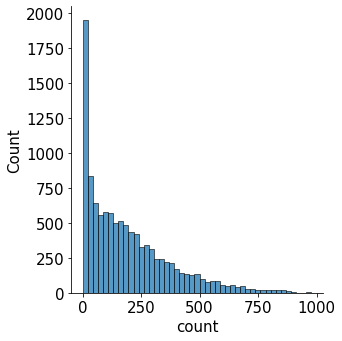

In [15]:
mpl.rc('font', size=15) #폰트크기 설정

sns.displot(train['count'])

* 0쪽으로 기울어진 분포도
* 정규분포로 변환하기 위해 로그변환

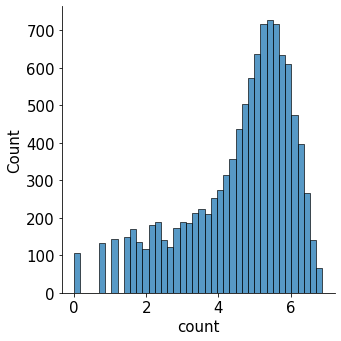

In [16]:
sns.displot(np.log(train['count']))



```
[질문 -현서]
plt, sns 그래프 용도 차이
```





```
[질문 -은서]
오른쪽으로 편향되어 있을 때도 로그변환하는지
[답변]
* 오른쪽으로 치우쳐져있을때가 흔하지 않고, 로그변환하지 않는다.
```





```
[질문]
* 완벽가이드에서는 lop1p()함수 썼는데 차이점?
```


---


```
[답변]
* rmsle 함수 정의할 때,  
  log1p 쓰면 오류를 방지하는 코드 안써도 됨.
  즉 더 간단하다!
```







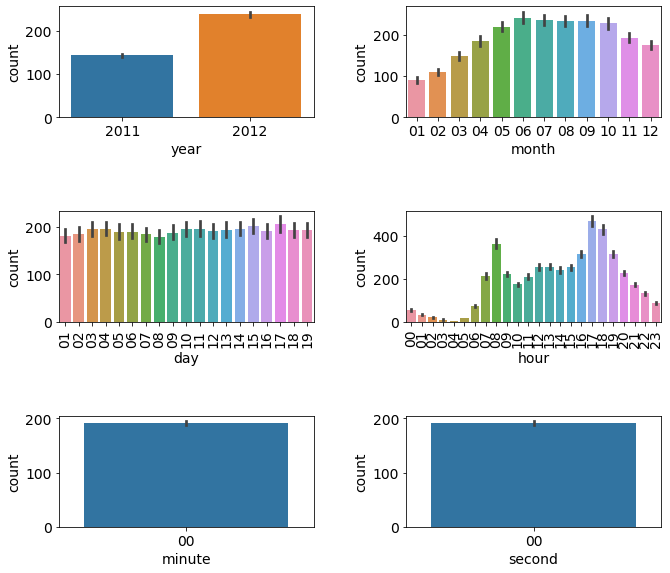

In [17]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
fig, axes = plt.subplots(nrows=3, ncols=2) #3행 2열 fig 생성
plt.tight_layout() #그래프 사이 여백확보
fig.set_size_inches(10, 9) #전체 fig 크기를 10x9인치로 설정

## 각 축에 서브플랏 할당
sns.barplot(x='year', y='count', data=train, ax=axes[0,0])
sns.barplot(x='month', y='count', data=train, ax=axes[0,1])
sns.barplot(x='day', y='count', data=train, ax=axes[1,0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1,1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2,0])
sns.barplot(x='second', y='count', data=train, ax=axes[2,1])

## 2행 x축 라벨들 90도 회전
axes[1,0].tick_params(axis='x', labelrotation=90)
axes[1,1].tick_params(axis='x', labelrotation=90)

1. year : 2011보다 2012에 대여량이 많다.
2. month : 1월이 가장 적고, 6월이 가장 많다. 날씨가 따뜻한 날 대여량이 많다.
3. day : train에는 1~19일만 있다.
4. hour : 출퇴근시간에 가장 많다.
5. minute, second에는 정보가 없다.

In [18]:
# day열 자세히
print(train['day'].value_counts().sort_index())
print(test['day'].value_counts().sort_index())

01    575
02    573
03    573
04    574
05    575
06    572
07    574
08    574
09    575
10    572
11    568
12    573
13    574
14    574
15    574
16    574
17    575
18    563
19    574
Name: day, dtype: int64
20    574
21    574
22    569
23    573
24    573
25    572
26    567
27    552
28    563
29    526
30    514
31    336
Name: day, dtype: int64


* train에는 1-19, test에는 20-30일이 나뉘어 있다.
* train, test에 공통된 값이 없으므로 피처로 사용할 수 없다. 

In [19]:
## minute, second 
print(train['minute'].value_counts())
print(train['second'].value_counts())

00    10886
Name: minute, dtype: int64
00    10886
Name: second, dtype: int64


* minute, second에는 00밖에 없음
* 정보가 없으므로 피처로 사용할 수 없다.

#### 2. 박스플랏
* 범주형 변수 (범주가 4개 이하)

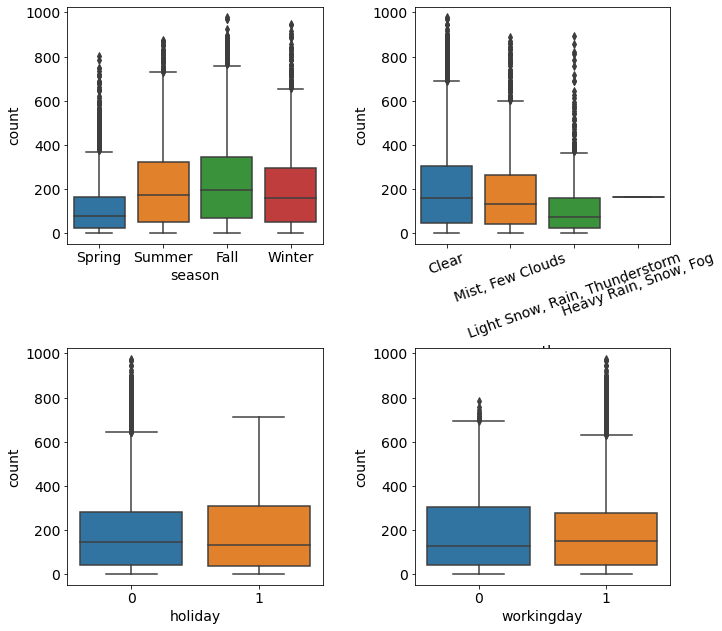

In [20]:
# 1. figure 준비
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
fig.set_size_inches(10, 10)

# 2. 박스플랏 할당
sns.boxplot(x='season', y='count', data=train, ax=axes[0,0])
sns.boxplot(x='weather', y='count', data=train, ax=axes[0,1])
sns.boxplot(x='holiday', y='count', data=train, ax=axes[1,0])
sns.boxplot(x='workingday', y='count', data=train, ax=axes[1,1]) 

# 3. 축회전
axes[0,1].tick_params(axis='x', labelrotation=20)

1. season : 봄에 가장 적고, 가을에 가장 많다.
2. weather : 날씨가 좋을수록 많다. 폭우, 폭설이 내리는 날씨에는 대여수량이 거의 없다. *이상치 1개 존재
3. holiday : 공휴일 0/1 중앙값이 비슷하다. 다만, 공휴일이 아닐때(0) 이상치가 많다. 
4. workingday : 공휴일과 마찬가지로, 0/1 중앙값이 비슷한다. 다만 근무일일때(1) 이상치가 많다.

#### 3. 포인트플랏
* 시간대별 대여 수량을 그린다. 
* 포인트플랏은 범주형 데이터에 따른 수치형 데이터의 평균과 신뢰구간을 점과 선으로 표시한다. 

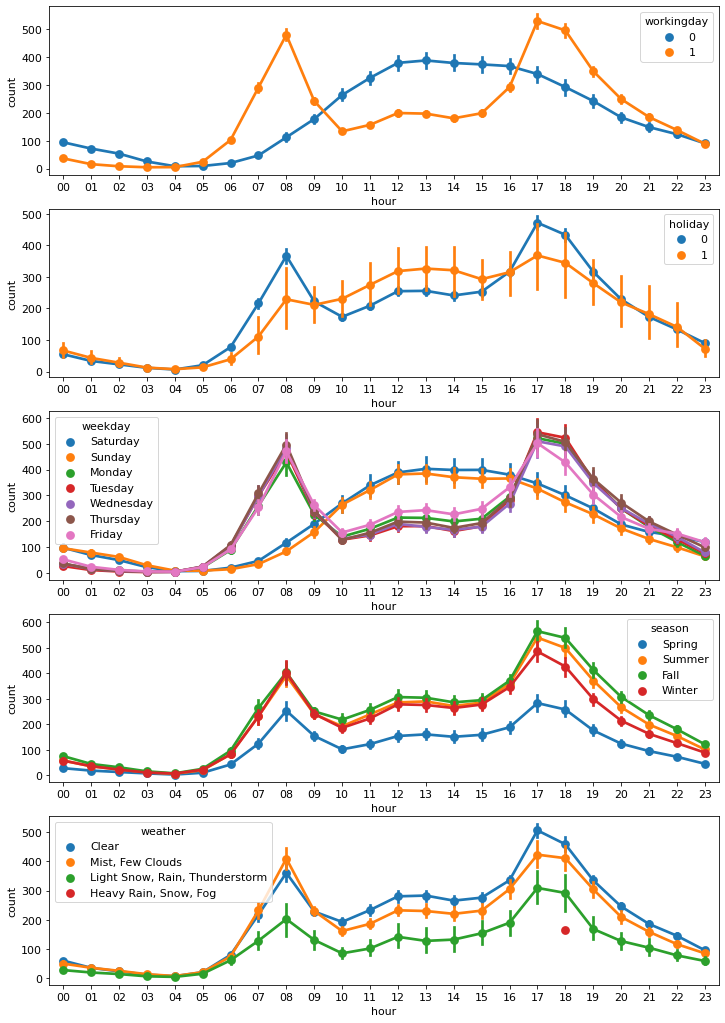

In [21]:
mpl.rc('font', size=11)
fig, axes = plt.subplots(nrows=5)
fig.set_size_inches(12, 18)

sns.pointplot(x='hour', y='count', data=train, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather', ax=axes[4])

1. workingday : 근무일에는 출퇴근시간대, 휴무일에는 낮시간대에 많다.
2. holiday : 공휴일아닐때는 출퇴근시간대, 공휴일에는 낮시간대에 많다.
3. weekday : 평일엔 출퇴근시간대, 주말엔 낮시간대에 많다.
4. season : 가을-여름-겨울-봄 순으로 많고, 공통적으로 출퇴근시간대에 많다.
5. weather : 날씨 좋을수록 많고, 공통적으로 출퇴근시간대에 많다. *heavy~일때 이상치가 존재한다. 


#### 4. 회귀선을 포함한 산점도
* 수치형 데이터 간의 상관관계 파악

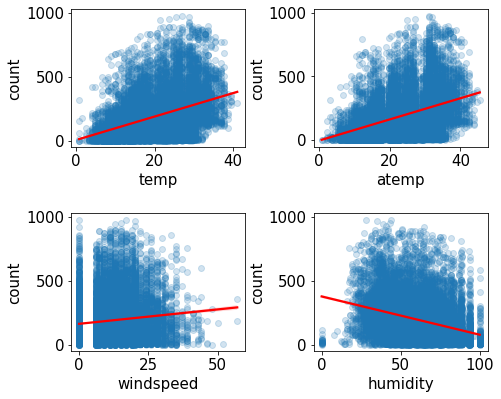

In [22]:
mpl.rc('font', size=15)
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
fig.set_size_inches(7,6)

sns.regplot(x='temp', y='count', data=train, ax=axes[0,0],
            scatter_kws={'alpha': 0.2}, line_kws={'color':'red'}) # 투명도, 선색깔
sns.regplot(x='atemp', y='count', data=train, ax=axes[0,1],
            scatter_kws={'alpha': 0.2}, line_kws={'color':'red'})
sns.regplot(x='windspeed', y='count', data=train, ax=axes[1,0],
            scatter_kws={'alpha': 0.2}, line_kws={'color':'red'})
sns.regplot(x='humidity', y='count', data=train, ax=axes[1,1],
            scatter_kws={'alpha': 0.2}, line_kws={'color':'red'})

1. temp, atemp : 온도, 체감온도 높을수록 대여량 많다.
2. humidity : 습기 낮을수록 대여량 많다.
3. windspeed : 풍속이 셀수록 대여량 많다.     
  -> 풍속이 약할수록 대여량이 많을 것으로 예상됨. 예상과 반대되는 결과    
  -> 0값이 많다.    
  => 결측치가 많을 가능성. 결측치 처리하거나 피처삭제

#### 5. 히트맵
* 수치형 데이터 끼리 어떤 상관관계 있는지 

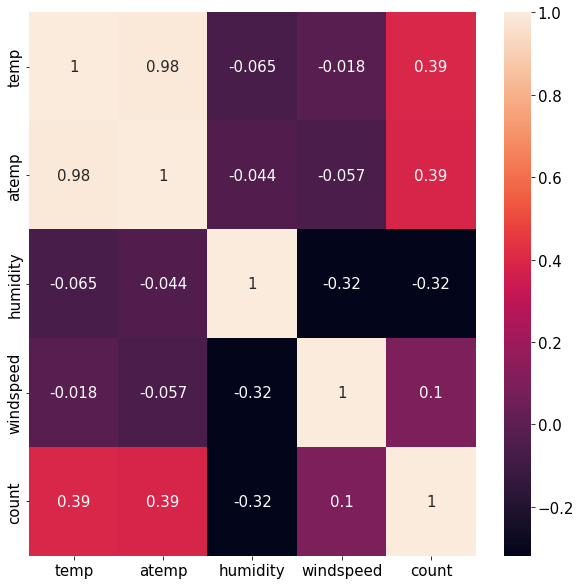

In [23]:
corr = train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corr, annot=True)



```
[질문]
annot 옵션 의미?
[답변]
사각형안에 상관계수가 숫자로 표시
```





```
[질문]
상관관계 높은 X 피처 처리해서 성능개선하기!
```



* count열과의 관계를 본다.
  1. temp, atemp : 양의 상관관계
  2. humidity : 음의 상관관계
  3. windspeed : 약한 상관관계

# 3) 베이스라인

* 위에서는 전처리의 편의를 위해 데이터 변형을 함.
* 다시 불러와서 모델링하기

In [24]:
train = pd.read_csv("/content/drive/MyDrive/ESAA/방학스터디/데이터셋/bike_train.csv")
test = pd.read_csv("/content/drive/MyDrive/ESAA/방학스터디/데이터셋/bike_test.csv")
submit = pd.read_csv("/content/drive/MyDrive/ESAA/방학스터디/데이터셋/bike_sampleSubmission.csv")

## (1) 피처 엔지니어링

In [25]:
# 이상치 제거
## weather = 4 (heav~)일때 이상치 존재

train = train[train['weather']!= 4 ] #4가 아닌 데이터만 추출

In [26]:
# 데이터 합치기 
## test데이터셋에는 count열이 없으므로 합칠때 NaN값으로 들어간다.

all_data_temp = pd.concat([train, test])
all_data_temp

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


* 데이터셋 테이블의 인덱스 마지막은 6492인데,   
  데이터셋 요약의 인덱스 마지막은 17379임
* 테이블에서 인덱스를 붙일때 중간에 0부터 다시 매겼기 때문

In [27]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [28]:
# 파생 변수 추가

all_data['date'] = all_data['datetime'].apply(lambda x : x.split()[0])
all_data['year'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[0])
all_data['month'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[1])
all_data['hour'] = all_data['datetime'].apply(lambda x : x.split()[1].split(':')[0])
all_data['weekday'] = all_data['date'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d").weekday())

* 테이블과 요약의 인덱스 마지막이 일치

In [29]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17378 non-null  object 
 1   season      17378 non-null  int64  
 2   holiday     17378 non-null  int64  
 3   workingday  17378 non-null  int64  
 4   weather     17378 non-null  int64  
 5   temp        17378 non-null  float64
 6   atemp       17378 non-null  float64
 7   humidity    17378 non-null  int64  
 8   windspeed   17378 non-null  float64
 9   casual      10885 non-null  float64
 10  registered  10885 non-null  float64
 11  count       10885 non-null  float64
 12  date        17378 non-null  object 
 13  year        17378 non-null  object 
 14  month       17378 non-null  object 
 15  hour        17378 non-null  object 
 16  weekday     17378 non-null  int64  
dtypes: float64(6), int64(6), object(5)
memory usage: 2.3+ MB


In [30]:
# lightgbm 돌릴 때 object라서 안돌아감 (나중에 drop할 변수는 처리안해줌)
all_data['year'] = all_data['year'].astype('int64')
all_data['hour'] = all_data['hour'].astype('int64')

In [31]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17378 non-null  object 
 1   season      17378 non-null  int64  
 2   holiday     17378 non-null  int64  
 3   workingday  17378 non-null  int64  
 4   weather     17378 non-null  int64  
 5   temp        17378 non-null  float64
 6   atemp       17378 non-null  float64
 7   humidity    17378 non-null  int64  
 8   windspeed   17378 non-null  float64
 9   casual      10885 non-null  float64
 10  registered  10885 non-null  float64
 11  count       10885 non-null  float64
 12  date        17378 non-null  object 
 13  year        17378 non-null  int64  
 14  month       17378 non-null  object 
 15  hour        17378 non-null  int64  
 16  weekday     17378 non-null  int64  
dtypes: float64(6), int64(8), object(3)
memory usage: 2.3+ MB


In [32]:
# 필요없는 피처 제거

drop_ft = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']
all_data_d1 = all_data.drop(drop_ft, axis=1)

* casual, registered : train에는 있으나 test에 없어서 분석불가
* datetime : 피처의 정보를 추출했으므로 필요없음
* date : 인덱스 역할이므로 필요없음
* windspeed : count(타깃값)과 상관관계가 약해서 제거
* month : season피처의 대분류 성격이라서 제거



```
[배운 점] 
필요없는 변수를 제거하는 방법을 잘 몰랐는데 
필요없는 변수를 제거하는 다양한 기준과 방법에 대해 배웠다.

변수선택은 모델 성능에 큰 영향을 준다.
타깃값 예측과 관련없는 피처가 많다면 예측성능에 떨어진다.
```



In [33]:
all_data_d1.head()

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,4,5


In [34]:
# 데이터 나누기
train = all_data_d1[~pd.isnull(all_data_d1['count'])] #count열이 nan값이 아니다.
test = all_data_d1[pd.isnull(all_data_d1['count'])] #count열이 있는데 nan값이다.

# train에서 타깃값 count 제거
train_y = np.log1p(train['count'])
train_x = train.drop(['count'], axis=1)
test_x = test.drop(['count'], axis=1)

## (2) 평가지표 함수

In [35]:
# 평가지표 계산함수
import numpy as np

def rmsle0(y_true, y_pred, convertExp=True):
  # 지수변환
  # 타깃값 count를 log변환할 것이기 때문에, 지수변환을 다시 해줘야함.
  if convertExp: # =convertExp=True이면 
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)

  # 로그변환 후 결측값을 0으로 변환
  # rmsle구할때는 로그변환값을 사용해야
  log_true = np.nan_to_num(np.log(y_true+1))
  log_pred = np.nan_to_num(np.log(y_pred+1))

  # RMSLE 계산
  output = np.sqrt(np.mean((log_true-log_pred)**2))
  return output

In [36]:
# 평가지표 계산함수
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
  # RMSLE 계산
  output = np.sqrt(np.mean((y_true-y_pred)**2))
  return output



```
[질문]
log1p 함수를 이용하면 '로그변환 후 결측값처리' 코드를 안써도 되지 않을까?
rmsle를 구할 때 log1p함수 써도 되는지?

[답변]

```





```
[질문]
왜 평가지표를 rmsle를 쓰는지?
y레이블을 로그변환해서 rmsle 쓰는건가
오차가 너무 커서 로그씌워서 에러구하는건가

[답변]
* 이상치에 민감하지 않다.
* RMSE와 달리 RMSLE는 예측값과 실제값의 상대적 에러(즉, 비율)를 측정해준다. 
  * 예측값=실제값 이면, RMSLE=sqrt(log(예/실))=log(1)=0
  * RMSE는 예측값과 실제값의 덧셈적 차이이고
    RMSLE는 예측값과 실제값의 비율적 차이이다.
* MAE vs RMSE : MAE와 달리 RMSE는 큰오류값 차이에 대해 크게 패널티를 주는 이점이 있다. 
  즉, 특이 케이스에서 큰 오류가 났어도 RMSE가 크게 튀지 않는다. 
* RMSE vs RMSLE : RMSE에 log를 취한 RMSLE는 큰오류가 전체에 지나친 영향을 미치지 못하게 더 잘 막는다.
  * ex. 집값에서 서울집값은 10~50억, 오류가 10억정도 나는데, 시골집값은 1~5억이고 오류가 몇천정도 나면
      서울집값에서 나는 오류의 영향을 줄여준다.
```



## (3) 모델 훈련

In [37]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_tr_test, y_train, y_tr_test = train_test_split(train_x, train_y, test_size=0.2, random_state=156)

### 1> Linear Regression

In [38]:
# 모델링
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
preds = linear_reg_model.predict(X_tr_test) 
rmsle(y_tr_test, preds, True)

0.9997691219925929

### 2> RandomForest

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_tr_test)
rmsle(y_tr_test, rf_pred)

0.30821599198409766

In [40]:
# 그리드 서치

from sklearn.model_selection import GridSearchCV

rf_params = {
    'n_estimators':[100,150, 200],
    'max_depth':[6,8,10]
    #'min_samples_leaf':[6,8,12,18],
    #'min_samples_split':[4,8,16,20]
}
rf_grid = GridSearchCV(rf_reg, param_grid=rf_params, cv=3)
rf_grid.fit(X_train, y_train)

print(rf_grid.best_params_)

{'max_depth': 10, 'n_estimators': 100}


In [41]:
preds_grid = rf_grid.best_estimator_.predict(X_tr_test)
rmsle(y_tr_test, preds_grid, True)

0.3380512132799602

* 기본 모델보다 그리드서치 결과에서 rmsle의 성능이 향상되지 않았다.

In [42]:
# 랜덤 서치

from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators':range(100,251, 50),
    'max_depth':range(5, 31, 5),
    'min_samples_leaf':range(3,16,3),
    'min_samples_split':range(3,16,3)
}
rf_rd = RandomizedSearchCV(rf_reg, param_distributions=rf_params, n_iter=30, cv=5)
rf_rd.fit(X_train, y_train)

print(rf_rd.best_params_)

{'n_estimators': 200, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 15}


In [43]:
preds_rd = rf_rd.best_estimator_.predict(X_tr_test)
rmsle(y_tr_test, preds_rd, True)

0.31483403359041395

* 그리드서치보다 성능이 향상되긴 했지만 기본모델보다는 낮다.
* 그리드서치보다 더많은 파라미터로 했을 때 시간이 덜 걸렸다.
* 성능 : 그리드서치 < 랜덤서치 < 기본모델



```
[질문]
이 책은 모델 적합을 특이하게 한다...
그리드서치x vs o vs 랜덤서치
```





```
[질문]
train_test_split 써서 모델링해오기
```





```
[질문]
scoring 옵션? : best param 찾는 기준
[답변]
* scoring 옵션 
- 성능평가기준 / best param찾는 기준
- RMSLE : scoring='neg_mean_squared_log_error'
```



### 3> LightGBM

In [44]:
from lightgbm import LGBMRegressor

lgbm_reg = LGBMRegressor(random_state=42)

evals = [(X_tr_test, y_tr_test)]
lgbm_reg.fit(X_train, y_train,
             early_stopping_rounds=100, eval_set=evals, eval_metric="rmsle", verbose=-1)
lgbm_pred = lgbm_reg.predict(X_tr_test)
rmsle(y_tr_test, lgbm_pred)

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.084511


0.29070778779271506

In [45]:
lgbm_params = {
    'num_leaves': range(10, 100, 10),
    'max_depth': range(10, 100, 10),
    #'subsample': range(0.5, 1.1, 0.2),
    'subsample': [0.5, 0.8, 1]
}

lgbm_rd = RandomizedSearchCV(lgbm_reg, param_distributions=lgbm_params, n_iter=30, cv=5)
lgbm_rd.fit(X_train, y_train)

print(lgbm_rd.best_params_)

{'subsample': 0.8, 'num_leaves': 90, 'max_depth': 70}


In [46]:
lgbm_pred_rd = lgbm_rd.best_estimator_.predict(X_tr_test)
rmsle(y_tr_test, lgbm_pred_rd)

0.2873208204967185

* 랜덤서치한 결과가 더 성능이 좋다!

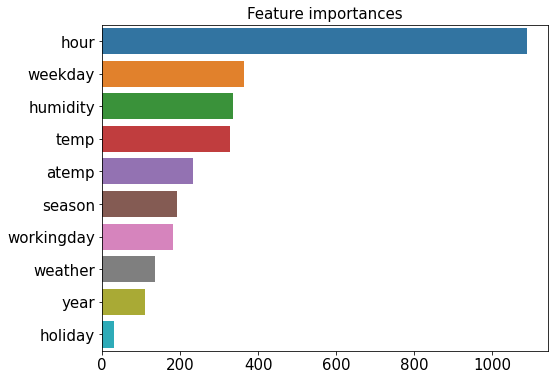

In [47]:
# feature 중요도

ftr_importances_values = lgbm_reg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

# 4) 성능개선

## * 기타
* optuna
  *  파라미터 관련 개념 내용이 많아서 다음시간에 한명씩 맡아서 설명해주는 식으로 하면 좋을듯
* pycarat

## (1) 스케일링
* 연속형 변수인 temp, atemp, humidity 에 스케일링을 해준다.

In [48]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,4,5


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

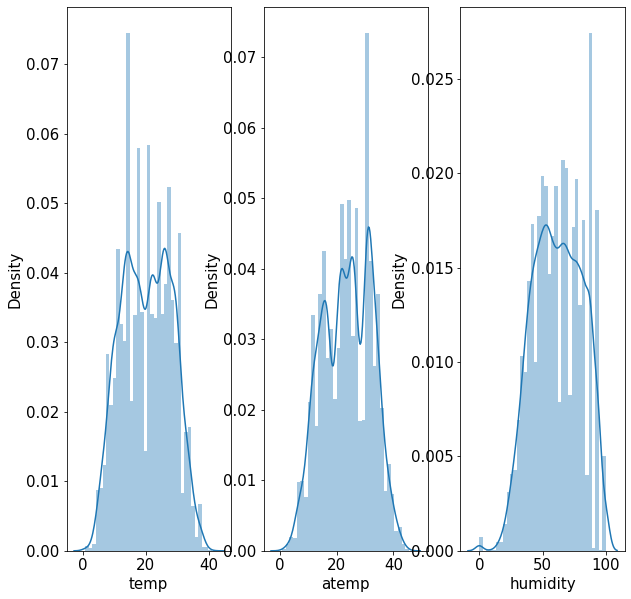

In [49]:
fig, axes = plt.subplots(ncols=3)
fig.set_size_inches(10, 10)

sns.distplot(train_x['temp'], ax=axes[0])
sns.distplot(train_x['atemp'], ax=axes[1])
sns.distplot(train_x['humidity'], ax=axes[2])

In [50]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mm = MinMaxScaler() 
ss = StandardScaler() 

temp_arr = np.array(train_x['temp']).reshape(-1,1)
atemp_arr = np.array(train_x['atemp']).reshape(-1,1)
humi_arr = np.array(train_x['humidity']).reshape(-1,1)

train_x['temp'] = pd.DataFrame(mm.fit_transform(temp_arr))
train_x['atemp'] = pd.DataFrame(mm.fit_transform(atemp_arr))
train_x['humidity'] = pd.DataFrame(mm.fit_transform(humi_arr))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

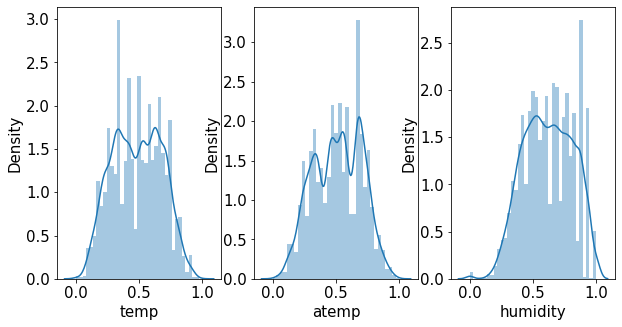

In [51]:
# 확인
fig, axes = plt.subplots(ncols=3)
fig.set_size_inches(10, 5)

sns.distplot(train_x['temp'], ax=axes[0])
sns.distplot(train_x['atemp'], ax=axes[1])
sns.distplot(train_x['humidity'], ax=axes[2])

In [52]:
## 스케일링 후 성능향상되었는지 확인
# train test split
from sklearn.model_selection import train_test_split
X_train, X_tr_test, y_train, y_tr_test = train_test_split(train_x, train_y, test_size=0.2, random_state=156)

lgbm_best = LGBMRegressor(random_state=42,
                          subsample=0.8, num_leaves=80, max_depth=90)

# lgbm randomsearch 모델링
evals = [(X_tr_test, y_tr_test)]
lgbm_best.fit(X_train, y_train,
                early_stopping_rounds=100, eval_set=evals, eval_metric="rmsle", verbose=-1)
lgbm_pred_best = lgbm_best.predict(X_tr_test)
rmsle(y_tr_test, lgbm_pred_best)

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[95]	valid_0's l2: 0.0804699


0.28367224496826715

* 그전 : 0.2837
* 성능개선 되었다!

## (2) windspeed변수 drop 하지 않고 결측치 처리
* '머신러닝 결측치 처리' 기능을 활용

In [53]:
all_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,2011,01,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,2011,01,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2011,01,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,2011,01,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,2011,01,4,5


In [54]:
# 필요없는 피처 제거 -windspeed는 제거하지 않는다.

drop_ft = ['casual', 'registered', 'datetime', 'date', 'month']
all_data_d2 = all_data.drop(drop_ft, axis=1)
all_data_d2.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,0.0,16.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,13.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,1.0,2011,4,5


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


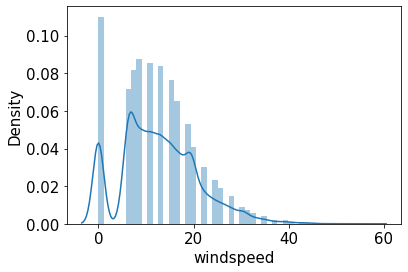

In [55]:
sns.distplot(all_data_d2['windspeed'])

* 0값이 매우 많아서 전에는 변수자체를 제거했다. 
* 바람속도가 0인것이 아니라, 측정불가한 경우일 수 있다.
* 따라서 이번에는 0값을 결측치로 처리한다. 

### A. 중앙값으로 대체

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


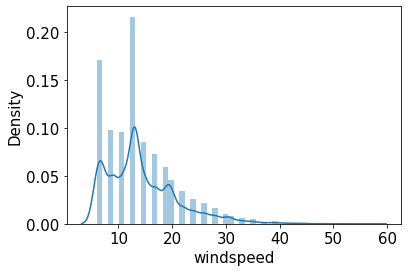

In [56]:
all_data_dA = all_data_d2.copy()
med = all_data_dA['windspeed'].median()
all_data_dA['windspeed'] = all_data_dA['windspeed'].replace(0, med)
sns.distplot(all_data_dA['windspeed'])

In [57]:
## 대체 후 성능향상되었는지 확인

# 데이터 나누기
train = all_data_dA[~pd.isnull(all_data_dA['count'])] #count열이 nan값이 아니다.
test = all_data_dA[pd.isnull(all_data_dA['count'])] #count열이 있는데 nan값이다.

# train에서 타깃값 count 제거
train_y = np.log1p(train['count'])
train_x = train.drop(['count'], axis=1)
test_x = test.drop(['count'], axis=1)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_tr_test, y_train, y_tr_test = train_test_split(train_x, train_y, test_size=0.2, random_state=156)

lgbm_best = LGBMRegressor(random_state=42,
                          subsample=0.8, num_leaves=80, max_depth=90)

# lgbm randomsearch 모델링
evals = [(X_tr_test, y_tr_test)]
lgbm_best.fit(X_train, y_train,
                early_stopping_rounds=100, eval_set=evals, eval_metric="rmsle", verbose=-1)
lgbm_pred_best = lgbm_best.predict(X_tr_test)
rmsle(y_tr_test, lgbm_pred_best)

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0796776


0.2822722465988839

* 그전 : 0.2837 / 0.2836
* 성능개선 되었다!

### B. 최빈값으로 대체

ModeResult(mode=array([0.]), count=array([2180]))


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


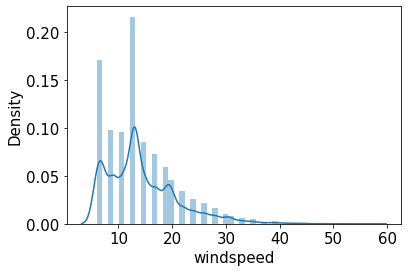

In [58]:
all_data_dB = all_data_d2.copy()

from scipy.stats import mode
print(mode(all_data_dB['windspeed']))

all_data_dB['windspeed'] = all_data_dB['windspeed'].replace(0, 12.998)
sns.distplot(all_data_dB['windspeed'])

In [59]:
## 대체 후 성능향상되었는지 확인

# 데이터 나누기
train = all_data_dB[~pd.isnull(all_data_dB['count'])] #count열이 nan값이 아니다.
test = all_data_dB[pd.isnull(all_data_dB['count'])] #count열이 있는데 nan값이다.

# train에서 타깃값 count 제거
train_y = np.log1p(train['count'])
train_x = train.drop(['count'], axis=1)
test_x = test.drop(['count'], axis=1)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_tr_test, y_train, y_tr_test = train_test_split(train_x, train_y, test_size=0.2, random_state=156)

lgbm_best = LGBMRegressor(random_state=42,
                          subsample=0.8, num_leaves=80, max_depth=90)

# lgbm randomsearch 모델링
evals = [(X_tr_test, y_tr_test)]
lgbm_best.fit(X_train, y_train,
                early_stopping_rounds=100, eval_set=evals, eval_metric="rmsle", verbose=-1)
lgbm_pred_best = lgbm_best.predict(X_tr_test)
rmsle(y_tr_test, lgbm_pred_best)

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0796776


0.2822722465988839

* 그전 : 0.2837 / 0.2836 /0.28227
* 바로 위케이스와 성능이 같다.

**Several ways for imputing missing data**
1. mean/median/mode imputation
    * 쉽고 빠르다.
    * 정확하지 않다.
    * 피처간 상관관계가 고려x

2. zero/constant imputation
    * 쉽고 빠르다.
    * 범주형 변수에 잘 작동함
    * 피처간 상관관계가 고려x
    * 데이터에 bias 만들 수 있음

3. KNN imputation
    * 정확하다
    * 이상치에 민감

(Single Imputation)   
4. Hot Deck Imputation    
    : 관련된 비슷한 데이터셋에서 랜덤하게 선택
5. Cold Deck Imputation    
    : 관련된 비슷한 데이터셋에서 규칙을 가지고 선택
6. Regression Imputation    
    : 같은 데이터셋에 있는 열에서 회귀예측하여 대체
7. Stochastic Regression Imputation     
    : 같은 데이터셋에 있는 열에서 회귀예측한 값의 잔차값을 더하여 대체

(https://www.theanalysisfactor.com/seven-ways-to-make-up-data-common-methods-to-imputing-missing-data/)

### C. Regression Imputation
(https://suy379.tistory.com/143)

* 위 설명 중 regression imputation 방법을 쓴다. 




In [60]:
all_data_dC = all_data_d2.copy()

# 데이터 나누기
train_w = all_data_dC[~pd.isnull(all_data_dC['count'])] #count열이 nan값이 아니다.
test_w = all_data_dC[pd.isnull(all_data_dC['count'])] #count열이 있는데 nan값이다.

# 비율 확인
print( round( len(train_w.loc[train_w['windspeed']==0]) / len(train_w) *100 ,2 ) ) #train에서 0비율
print( round( len(test_w.loc[test_w['windspeed']==0]) / len(test_w) *100 ,2 ) ) #test에서 0비율

12.06
13.35


* regression impuation
  1. 결측치인 부분(zero)과 결측치가 아닌 부분(nonzero)으로 나눠 데이터를 2개로 쪼갠다. 
  2. nonzero데이터셋으로 학습한 뒤,   
      zero데이터셋에 대한 예측을 수행한다.
  * 변수간 상관관계가 고려되나, 예측치간 variability가 보존되지 못한다.
  3. 이때, test데이터셋에도 0이 13%가 되므로 train데이터셋의 0을 모조리 회귀예측값으로 채워버리면 안된다.    
  따라서 train데이터셋의 0비율 절반인 6%에 대해서만 회귀예측값으로 채운다.

* df = df_nonzero + df_zero   
  df = 0이 아닌 애들 + 0인 애들    
  df = 학습에 사용됨 + (회귀예측값 + 그냥 놔둠)     

* df_zero = df_zero_use + df_zero_keep    
  df_zero = 회귀예측값으로 채우기 + 그냥놔둠    
  df_zero = 6% + 6%

In [61]:
## df_zero 만들기
df = train_w.copy()
df_zero = df[df['windspeed']==0]
print(len(df_zero))

## df_zero_keep 만들기
df_zero_keep = df_zero.sample(round(len(train_w)*0.06), random_state=99)
print(len(df_zero_keep))
# 6%로는 회귀예측값으로 채운다. 
# 나머지 6%로는 그냥 0으로 놔둔다.

1313
653


In [62]:
## df_zero_use 만들기
df_zero1 = df_zero.reset_index()
df_zero_keep1 = df_zero_keep.reset_index() 

display(df_zero1.head())
display(df_zero_keep1.head())
# 인덱스가 생성됨

df_zero_use = df_zero1.loc[~df_zero1['index'].isin(df_zero_keep1['index'].tolist())]
                      # zero1의 인덱스 중에서 zero_keep1의 인덱스를 포함하지 않는 애들만 추출
# 즉 zero1에서 zero_keep1인 애들 빼기
df_zero_use.set_index(['index'], inplace=True)
display(df_zero_use.head())

,index,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,weekday
0,0,1,0,0,1,9.84,14.395,81,0.0,16.0,2011,0,5
1,1,1,0,0,1,9.02,13.635,80,0.0,40.0,2011,1,5
2,2,1,0,0,1,9.02,13.635,80,0.0,32.0,2011,2,5
3,3,1,0,0,1,9.84,14.395,75,0.0,13.0,2011,3,5
4,4,1,0,0,1,9.84,14.395,75,0.0,1.0,2011,4,5


,index,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,weekday
0,2459,2,0,1,1,31.16,34.850,55,0.0,213.0,2011,9,4
1,5247,4,0,1,2,12.30,16.665,56,0.0,359.0,2011,17,0
2,1165,1,0,0,1,13.94,18.180,66,0.0,2.0,2011,6,6
3,8229,3,1,0,1,27.88,31.820,65,0.0,72.0,2012,7,2
4,9104,3,0,0,1,30.34,35.605,74,0.0,500.0,2012,18,6


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,weekday
index,,,,,,,,,,,,
0,1,0,0,1,9.84,14.395,81,0.0,16.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40.0,2011,1,5
4,1,0,0,1,9.84,14.395,75,0.0,1.0,2011,4,5
6,1,0,0,1,9.02,13.635,80,0.0,2.0,2011,6,5
9,1,0,0,1,13.12,17.425,76,0.0,14.0,2011,9,5


In [63]:
## df_nonzero 만들기
df_nonzero = df[df['windspeed']!=0]
df_nonzero.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,weekday
5,1,0,0,2,9.84,12.880,75,6.0032,1.0,2011,5,5
10,1,0,0,1,15.58,19.695,76,16.9979,36.0,2011,10,5
11,1,0,0,1,14.76,16.665,81,19.0012,56.0,2011,11,5
12,1,0,0,1,17.22,21.210,77,19.0012,84.0,2011,12,5
13,1,0,0,2,18.86,22.725,72,19.9995,94.0,2011,13,5


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


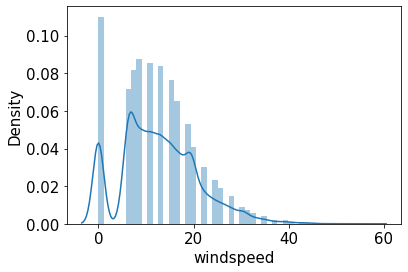

In [64]:
sns.distplot(all_data_d2['windspeed'])

* 밀도함수가 불연속적으로 나타남.   
  즉 범주형 변수라는 것임. 
* 따라서 회귀예측이 아니라 분류예측으로 해야되고,    
  변수타입을 정수/실수가 아닌 범주형으로 바꿔야 함.

In [65]:
df_zero['windspeed'] = df_zero['windspeed'].astype('str')
df_nonzero['windspeed'] = df_nonzero['windspeed'].astype('str')
df_zero_use['windspeed'] = df_zero_use['windspeed'].astype('str')
df_zero_keep['windspeed'] = df_zero_keep['windspeed'].astype('str')

df_nonzero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 5 to 10884
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      9572 non-null   int64  
 1   holiday     9572 non-null   int64  
 2   workingday  9572 non-null   int64  
 3   weather     9572 non-null   int64  
 4   temp        9572 non-null   float64
 5   atemp       9572 non-null   float64
 6   humidity    9572 non-null   int64  
 7   windspeed   9572 non-null   object 
 8   count       9572 non-null   float64
 9   year        9572 non-null   int64  
 10  hour        9572 non-null   int64  
 11  weekday     9572 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 972.2+ KB


<ipython-input-65-fa69d03a0444>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zero['windspeed'] = df_zero['windspeed'].astype('str')
<ipython-input-65-fa69d03a0444>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonzero['windspeed'] = df_nonzero['windspeed'].astype('str')
<ipython-input-65-fa69d03a0444>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

* 범주형으로 바꿀 대 object로 바꾸면 모델 안돌아감.     
str로 바꿔야함.

In [66]:
## 예측 수행 
X_train_wind = df_nonzero[['season', 'weather', 'temp', 'atemp', 'humidity', 'year']]
y_train_wind = df_nonzero['windspeed']
X_test_wind = df_zero_use[['season', 'weather', 'temp', 'atemp', 'humidity', 'year']]
# windspeed 예측과 관련된 변수만 추출

from sklearn.ensemble import RandomForestClassifier
rf_wind = RandomForestClassifier(random_state=42)

from lightgbm import LGBMClassifier
lgbm_wind = LGBMClassifier(random_state=42)

lgbm_wind.fit(X_train_wind, y_train_wind)
pred_wind = lgbm_wind.predict(X_test_wind)

In [67]:
# 새로운 데이터프레임 생성
df_zero_new = df_zero_use.copy()
df_zero_new['windspeed'] = pred_wind
df_zero_new.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,weekday
index,,,,,,,,,,,,
0,1,0,0,1,9.84,14.395,81,8.9981,16.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,8.9981,40.0,2011,1,5
4,1,0,0,1,9.84,14.395,75,8.9981,1.0,2011,4,5
6,1,0,0,1,9.02,13.635,80,8.9981,2.0,2011,6,5
9,1,0,0,1,13.12,17.425,76,8.9981,14.0,2011,9,5


* 새로운 예측값들로 채워짐

In [68]:
# 3개 데이터셋 합치고 다시 train으로 저장
train_w = pd.concat([df_zero_new, df_zero_keep, df_nonzero], ignore_index = True)
train_w['windspeed'] = train_w['windspeed'].astype('float')
print('train data에서 windspeed 0의 비율:' , round((len(train_w.loc[train_w['windspeed']==0]) / len(train_w))*100 , 2), '%')
display(train_w.head())

train data에서 windspeed 0의 비율: 6.0 %


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,8.9981,16.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,8.9981,40.0,2011,1,5
2,1,0,0,1,9.84,14.395,75,8.9981,1.0,2011,4,5
3,1,0,0,1,9.02,13.635,80,8.9981,2.0,2011,6,5
4,1,0,0,1,13.12,17.425,76,8.9981,14.0,2011,9,5


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


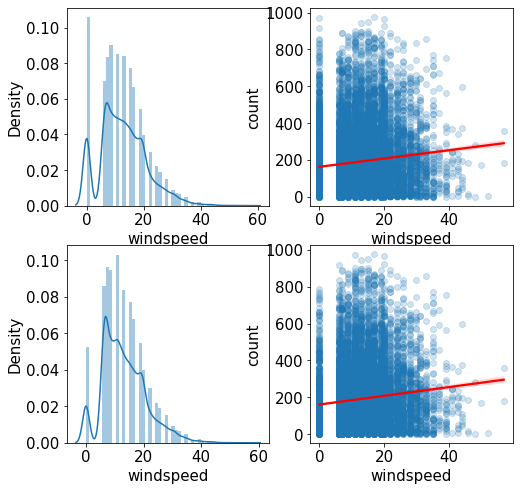

In [69]:
train_bf = all_data_d2[~pd.isnull(all_data_d2['count'])] #count열이 nan값이 아니다.


fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(8,8)

sns.distplot(train_bf['windspeed'], ax=axes[0,0])
sns.regplot(x='windspeed', y='count', data=train_bf, ax=axes[0,1],
             scatter_kws={'alpha': 0.2}, line_kws={'color':'red'})
sns.distplot(train_w['windspeed'], ax=axes[1,0])
sns.regplot(x='windspeed', y='count', data=train_w, ax=axes[1,1],
             scatter_kws={'alpha': 0.2}, line_kws={'color':'red'})

In [70]:
print(train_bf[['windspeed', 'count']].corr())
print(train_w[['windspeed', 'count']].corr())

           windspeed     count
windspeed   1.000000  0.101361
count       0.101361  1.000000
           windspeed     count
windspeed   1.000000  0.099518
count       0.099518  1.000000


* 상관관계가 더 떨어졌다. 
* 변수 제거하는거보다 성능향상될지 모르겠다...

In [71]:
## 대체 후 성능향상되었는지 확인 

# 스케일링

mm = MinMaxScaler()
ss = StandardScaler()

temp_arr = np.array(train_w['temp']).reshape(-1,1)
atemp_arr = np.array(train_w['atemp']).reshape(-1,1)
humi_arr = np.array(train_w['humidity']).reshape(-1,1)
wind_arr = np.array(train_w['windspeed']).reshape(-1,1)

train_w['temp'] = pd.DataFrame(mm.fit_transform(temp_arr))
train_w['atemp'] = pd.DataFrame(mm.fit_transform(atemp_arr))
train_w['humidity'] = pd.DataFrame(mm.fit_transform(humi_arr))
train_w['windspeed'] = pd.DataFrame(mm.fit_transform(wind_arr))

# train에서 타깃값 count 제거
train_y = np.log1p(train_w['count'])
train_x = train_w.drop(['count'], axis=1)
test_x = test_w.drop(['count'], axis=1)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_tr_test, y_train, y_tr_test = train_test_split(train_x, train_y, test_size=0.2, random_state=156)

In [72]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_tr_test)
rmsle(y_tr_test, pred) #0.3127

0.31345249560887667

In [73]:
lgbm_reg = LGBMRegressor(random_state=42)
lgbm_reg.fit(X_train, y_train)
pred = lgbm_reg.predict(X_tr_test)
rmsle(y_tr_test, pred) #0.299

0.2998947928467376

In [74]:
lgbm_params = {
    'num_leaves': range(10, 100, 10),
    'max_depth': range(10, 100, 10),
    #'subsample': range(0.5, 1.1, 0.2),
    'subsample': [0.5, 0.8, 1]
}

lgbm_reg = LGBMRegressor(random_state=42)
lgbm_rd = RandomizedSearchCV(lgbm_reg, param_distributions=lgbm_params, n_iter=30, cv=5)
lgbm_rd.fit(X_train, y_train)
lgbm_pred_rd = lgbm_rd.best_estimator_.predict(X_tr_test)
rmsle(y_tr_test, lgbm_pred_rd) #0.290

0.2902414965020654

* 그전 : 0.2837 / 0.2836 /0.28227
* 성능이 향상되지 않았다;;
* submission에서는 어떻게 될지..

### D. 타겟변수 이상치 제거

### D-1. X피처에서 windspeed 드롭

In [75]:
print(train.shape)
train_out = train.copy()
train_out = train[train['count'] - train['count'].mean() < 3*train['count'].std()]
print(train_out.shape)
display(train_out.head())

(10885, 12)
(10738, 12)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,12.998,16.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,12.998,40.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,12.998,32.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,12.998,13.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,12.998,1.0,2011,4,5


In [76]:
test_out = test.copy()
test_out = test[test['count'] - test['count'].mean() < 3*test['count'].std()]

* 3*표준편차 값을 초과하는 경우(?) 이상치로 제거하고 간주

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


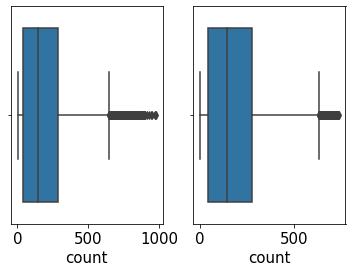

In [77]:
fig, axes = plt.subplots(ncols=2)
sns.boxplot(train['count'], ax=axes[0])
sns.boxplot(train_out['count'], ax=axes[1])

* 이상치가 줄어들었다.

In [78]:
## 타겟값 이상치제거 후 성능향상되었는지 확인 

# 스케일링

mm = MinMaxScaler()
ss = StandardScaler()

temp_arr = np.array(train_out['temp']).reshape(-1,1)
atemp_arr = np.array(train_out['atemp']).reshape(-1,1)
humi_arr = np.array(train_out['humidity']).reshape(-1,1)
#wind_arr = np.array(train_out['windspeed']).reshape(-1,1)

train_out['temp'] = pd.DataFrame(mm.fit_transform(temp_arr))
train_out['atemp'] = pd.DataFrame(mm.fit_transform(atemp_arr))
train_out['humidity'] = pd.DataFrame(mm.fit_transform(humi_arr))
#train_out['windspeed'] = pd.DataFrame(mm.fit_transform(wind_arr))

# train에서 타깃값 count 제거
train_y = np.log1p(train_out['count'])
train_x = train_out.drop(['count'], axis=1)
test_x = test_out.drop(['count'], axis=1)

<ipython-input-78-7b7f0d0fda14>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_out['temp'] = pd.DataFrame(mm.fit_transform(temp_arr))
<ipython-input-78-7b7f0d0fda14>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_out['atemp'] = pd.DataFrame(mm.fit_transform(atemp_arr))
<ipython-input-78-7b7f0d0fda14>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [79]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_tr_test)
rmsle(y_tr_test, pred) #0.3148

0.3122490462271796

In [80]:
lgbm_reg = LGBMRegressor()
lgbm_reg.fit(X_train, y_train)
pred = lgbm_reg.predict(X_tr_test)
rmsle(y_tr_test, pred) #0.299

0.2998947928467376

In [81]:
lgbm_params = {
    'num_leaves': range(10, 100, 10),
    'max_depth': range(10, 100, 10),
    #'subsample': range(0.5, 1.1, 0.2),
    'subsample': [0.5, 0.8, 1]
}
lgbm_reg = LGBMRegressor(random_state=42)
lgbm_rd = RandomizedSearchCV(lgbm_reg, param_distributions=lgbm_params, n_iter=30, cv=5)
lgbm_rd.fit(X_train, y_train)
lgbm_pred_rd = lgbm_rd.best_estimator_.predict(X_tr_test)
rmsle(y_tr_test, lgbm_pred_rd) #.0290

0.2901889017784544

### D-2 X피처에서 windspeed 추가 

In [83]:
train_out_w = train_w.copy()
train_out_w = train_w[train_w['count'] - train_w['count'].mean() < 3*train_w['count'].std()]
test_out_w = test_w.copy()
test_out_w = test_w[test_w['count'] - test_w['count'].mean() < 3*test_w['count'].std()]

## 타겟값 이상치제거 후 성능향상되었는지 확인 

# 스케일링

mm = MinMaxScaler()
ss = StandardScaler()

temp_arr = np.array(train_out_w['temp']).reshape(-1,1)
atemp_arr = np.array(train_out_w['atemp']).reshape(-1,1)
humi_arr = np.array(train_out_w['humidity']).reshape(-1,1)
wind_arr = np.array(train_out_w['windspeed']).reshape(-1,1)

train_out_w['temp'] = pd.DataFrame(mm.fit_transform(temp_arr))
train_out_w['atemp'] = pd.DataFrame(mm.fit_transform(atemp_arr))
train_out_w['humidity'] = pd.DataFrame(mm.fit_transform(humi_arr))
train_out_w['windspeed'] = pd.DataFrame(mm.fit_transform(wind_arr))

# train에서 타깃값 count 제거
train_y = np.log1p(train_out_w['count'])
train_x = train_out_w.drop(['count'], axis=1)
test_x = test_out_w.drop(['count'], axis=1)

lgbm_params = {
    'num_leaves': range(10, 100, 10),
    'max_depth': range(10, 100, 10),
    #'subsample': range(0.5, 1.1, 0.2),
    'subsample': [0.5, 0.8, 1]
}
lgbm_reg = LGBMRegressor(random_state=42)
lgbm_rd = RandomizedSearchCV(lgbm_reg, param_distributions=lgbm_params, n_iter=30, cv=5)
lgbm_rd.fit(X_train, y_train)
lgbm_pred_rd = lgbm_rd.best_estimator_.predict(X_tr_test)
rmsle(y_tr_test, lgbm_pred_rd) #.0290

<ipython-input-83-20680005fa8c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_out_w['temp'] = pd.DataFrame(mm.fit_transform(temp_arr))
<ipython-input-83-20680005fa8c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_out_w['atemp'] = pd.DataFrame(mm.fit_transform(atemp_arr))
<ipython-input-83-20680005fa8c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

0.2902414965020654

### E. atemp 변수 삭제
* temp와 atemp 상관성 높으므로 atemp 삭제해본다.

In [85]:
train_at = train_w.drop('atemp', axis=1)
test_at = test_w.drop('atemp', axis=1)

In [86]:
train_out_at = train_at.copy()
train_out_at = train_at[train_at['count'] - train_at['count'].mean() < 3*train_at['count'].std()]
test_out_at = test_at.copy()
test_out_at = test_at[test_at['count'] - test_at['count'].mean() < 3*test_at['count'].std()]

## 타겟값 이상치제거 후 성능향상되었는지 확인 

# 스케일링

mm = MinMaxScaler()
ss = StandardScaler()

temp_arr = np.array(train_out_at['temp']).reshape(-1,1)
#atemp_arr = np.array(train_out_at['atemp']).reshape(-1,1)
humi_arr = np.array(train_out_at['humidity']).reshape(-1,1)
wind_arr = np.array(train_out_at['windspeed']).reshape(-1,1)

train_out_at['temp'] = pd.DataFrame(mm.fit_transform(temp_arr))
#train_out_w['atemp'] = pd.DataFrame(mm.fit_transform(atemp_arr))
train_out_at['humidity'] = pd.DataFrame(mm.fit_transform(humi_arr))
train_out_at['windspeed'] = pd.DataFrame(mm.fit_transform(wind_arr))

# train에서 타깃값 count 제거
train_y = np.log1p(train_out_at['count'])
train_x = train_out_at.drop(['count'], axis=1)
test_x = test_out_at.drop(['count'], axis=1)

lgbm_params = {
    'num_leaves': range(10, 100, 10),
    'max_depth': range(10, 100, 10),
    #'subsample': range(0.5, 1.1, 0.2),
    'subsample': [0.5, 0.8, 1]
}
lgbm_reg = LGBMRegressor(random_state=42)
lgbm_rd = RandomizedSearchCV(lgbm_reg, param_distributions=lgbm_params, n_iter=30, cv=5)
lgbm_rd.fit(X_train, y_train)
lgbm_pred_rd = lgbm_rd.best_estimator_.predict(X_tr_test)
rmsle(y_tr_test, lgbm_pred_rd) #.0290

<ipython-input-86-236bdc35b4e5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_out_at['temp'] = pd.DataFrame(mm.fit_transform(temp_arr))
<ipython-input-86-236bdc35b4e5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_out_at['humidity'] = pd.DataFrame(mm.fit_transform(humi_arr))
<ipython-input-86-236bdc35b4e5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

0.2902414965020654